In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.font_manager import FontProperties
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from math import sqrt
import seaborn as sns

excel_path = r"D:\我的论文\河流水化学组成的时空变化特征及其影响因素的研究\data\离子浓度.xlsx"
df = pd.read_excel(excel_path, sheet_name=0)
mask = df.loc[:, '流域边长 km': ].columns
mask = ['重碳酸根离子(HCO3- ) mg/L'] + list(mask)
df = df.loc[:, mask]
# 查看df是否存在空值
null_values = df.isnull()
null_counts = null_values.sum()

#使用多项式插值补充缺失值

df_interpolate = df.interpolate(method='polynomial', order=5, axis=0)

# 查看df_interpolate是否存在空值
null_values = df_interpolate.isnull()
null_counts = null_values.sum()




Number of trees in RF is 25
Root Mean Squared Error (RMSE): 0.05182309020986314
R-squared: 0.6482947197482902

流域边长 km: 0.04814839285757945
流域面积 km²: 0.00527902370698206
海拔 m: 0.002899106689167883
最高海拔 m: 0.006593842673844165
最低海拔 m: 0.00582691871653482
平均坡度 °: 0.011633905197470342
最大坡度 °: 0.03268048701445696
最小坡度 °: 0.0003895882525494456
气温 ℃: 0.021375005513582117
地表温度 ℃: 0.02168718059047651
降水 mm: 0.012181256548497915
风速 m/s: 0.019236901334561494
潜热LH W/m²: 0.026611118357224645
Ec W/m²: 0.021303279592749854
Ei W/m²: 0.015059468396849473
Es W/m²: 0.015943892199281547
ET_water W/m²: 0.02761046583433304
GPP g C/m²/day: 0.025886865980501706
NDVI: 0.017836162793096546
LAI: 0.013522746938609826
光合有效辐射PAR W/m²: 0.04115880992531014
光合有效辐射吸收比FAPAR %: 0.029555598055988452
SPEI: 0.02246921315304786
surface soil water %: 0.04086692346534274
bulk density g/cm³: 0.005329354628521217
electric conductivity dS/m: 0.006720086738841535
C/N_ratio: 0.31040052561303827
coarse %: 0.048594188541591574
gy

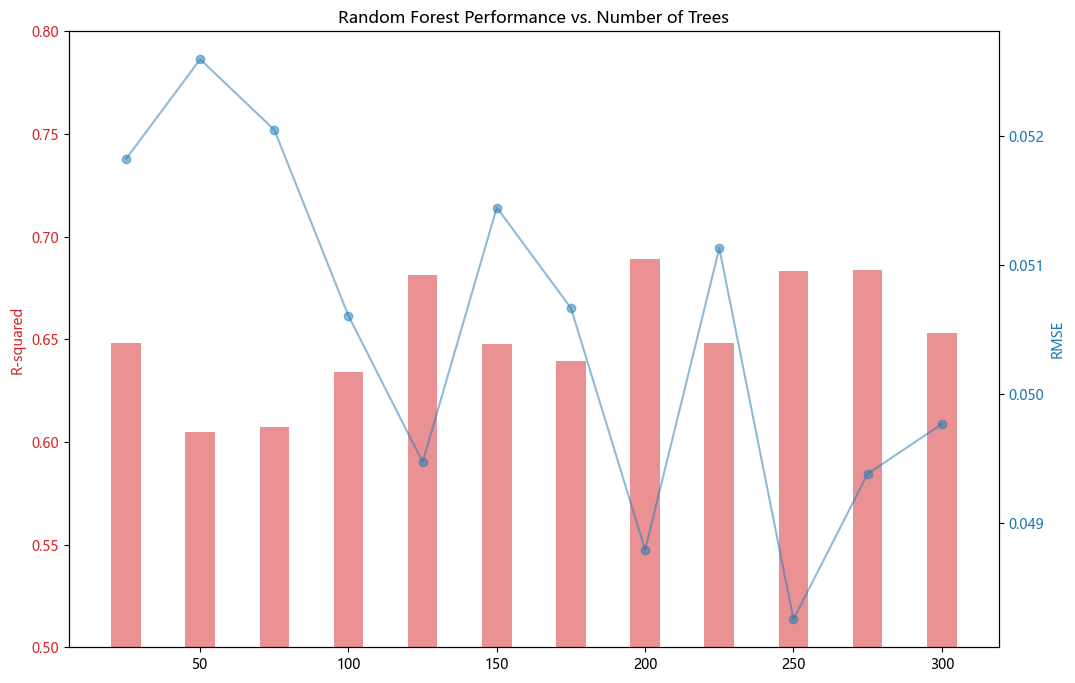

In [20]:
# 特征和标签
x = df_interpolate.drop('重碳酸根离子(HCO3- ) mg/L', axis=1)
t = df_interpolate['重碳酸根离子(HCO3- ) mg/L']

# 对整个数据集进行标准化处理
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
t_scaled = scaler.fit_transform(t.values.reshape(-1, 1))

column_names = x.columns.to_list()
tree_rmse_dict = {}
tree_r2_dict = {}

# 超参数
tree_numbers = list(range(25, 325, 25))
matplotlib.rcParams['font.family'] = 'Microsoft YaHei'

# 划分训练集和测试集
x_train, x_test, t_train, t_test = train_test_split(x_scaled, t_scaled, test_size=0.2, random_state=seed_value)
all_tree_numbers = []

for tree_number in tree_numbers:
    print(f"\n\n\nNumber of trees in RF is {tree_number}")
    model = RandomForestRegressor(n_estimators=tree_number)
    # 初始化交叉验证
    kf = KFold(n_splits=5, shuffle=True)

    rmse_list = []
    r2_list = []
    feature_importances_list = []

    predictions_list, true_values_list = [], []

    for train_index, test_index in kf.split(x_train):
        x_fold_train, x_fold_test = x_train[train_index], x_train[test_index]
        t_fold_train, t_fold_test = t_train[train_index], t_train[test_index]
        model.fit(x_fold_train, t_fold_train.flatten())

        y = model.predict(x_fold_test)
        predictions_list.extend(y)
        true_values_list.extend(t_test)

        rmse = sqrt(mean_squared_error(t_test, y))
        r2 = r2_score(t_test, y)
        rmse_list.append(rmse)
        r2_list.append(r2)
        feature_importances_list.append(model.feature_importances_)
        all_tree_numbers.extend([tree_number] * len(t_test))  

    avg_rmse = np.mean(rmse_list)
    avg_r2 = np.mean(r2_list)

    print(f'Root Mean Squared Error (RMSE): {avg_rmse}')
    print(f"R-squared: {avg_r2}\n")
    avg_feature_importances = np.mean(feature_importances_list, axis=0)
    for feature, importance in zip(column_names, avg_feature_importances):
        print(f"{feature}: {importance}")
    if tree_number not in tree_rmse_dict:
        tree_rmse_dict[tree_number] = {'None': []}
    if tree_number not in tree_r2_dict:
        tree_r2_dict[tree_number] = {'None': []}
    tree_rmse_dict[tree_number]['None'].append(avg_rmse)
    tree_r2_dict[tree_number]['None'].append(avg_r2)


fig, ax1 = plt.subplots(figsize=(12, 8))

# 绘制柱状图（R方）
color = 'tab:red'
ax1.set_ylabel('R-squared', color=color)
ax1.bar(tree_numbers, [tree_r2_dict[tree_number]['None'][0] for tree_number in tree_numbers], color=color, alpha=0.5, label='R-squared', width=10)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0.5, 0.8)

# 创建第二个 Y 轴
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_xlabel('Number of Trees')
ax2.set_ylabel('RMSE', color=color)
ax2.plot(tree_numbers, [tree_rmse_dict[tree_number]['None'][0] for tree_number in tree_numbers], marker='o', color=color, alpha=0.5, label='RMSE')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Random Forest Performance vs. Number of Trees')
plt.show()




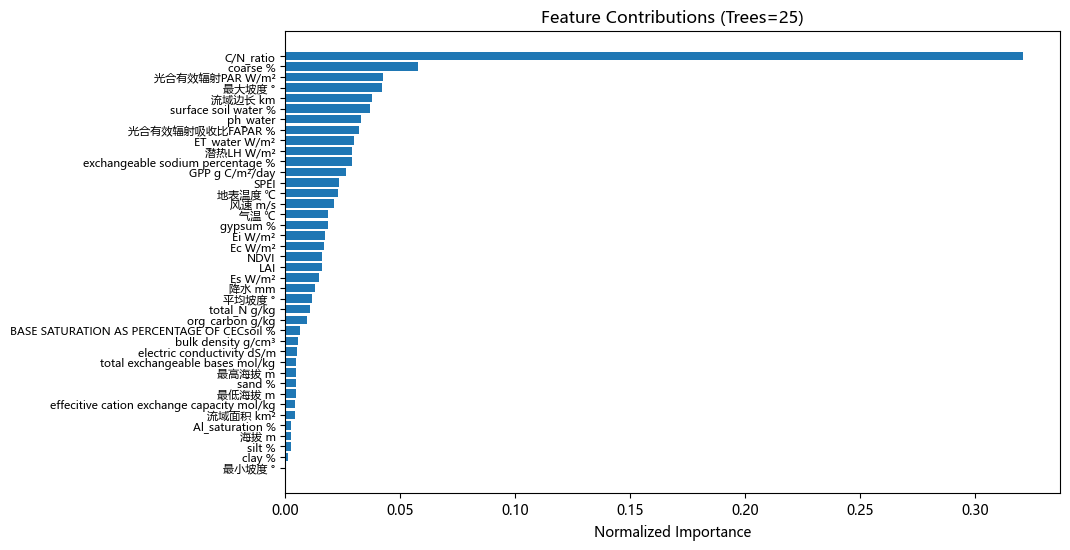

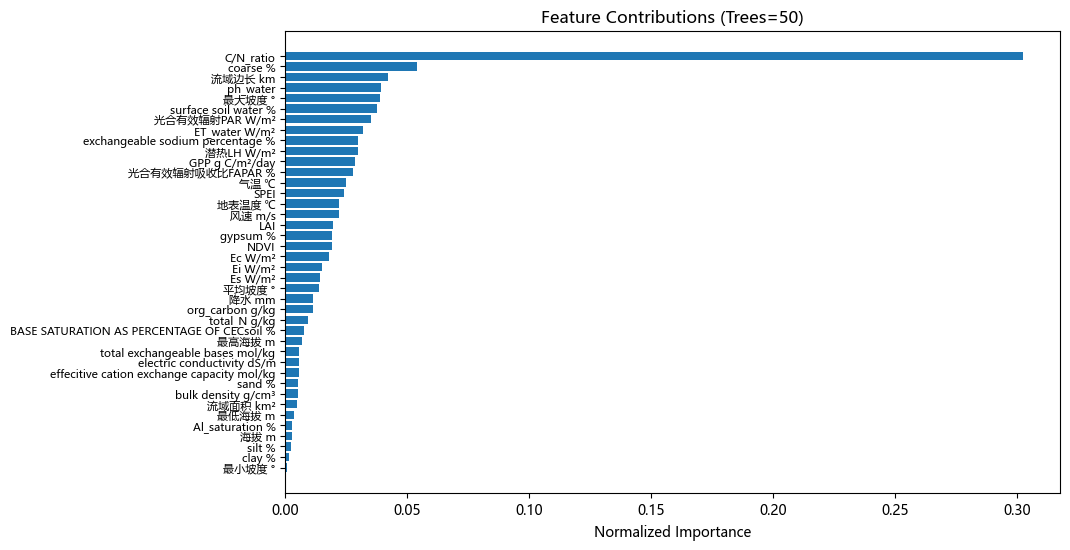

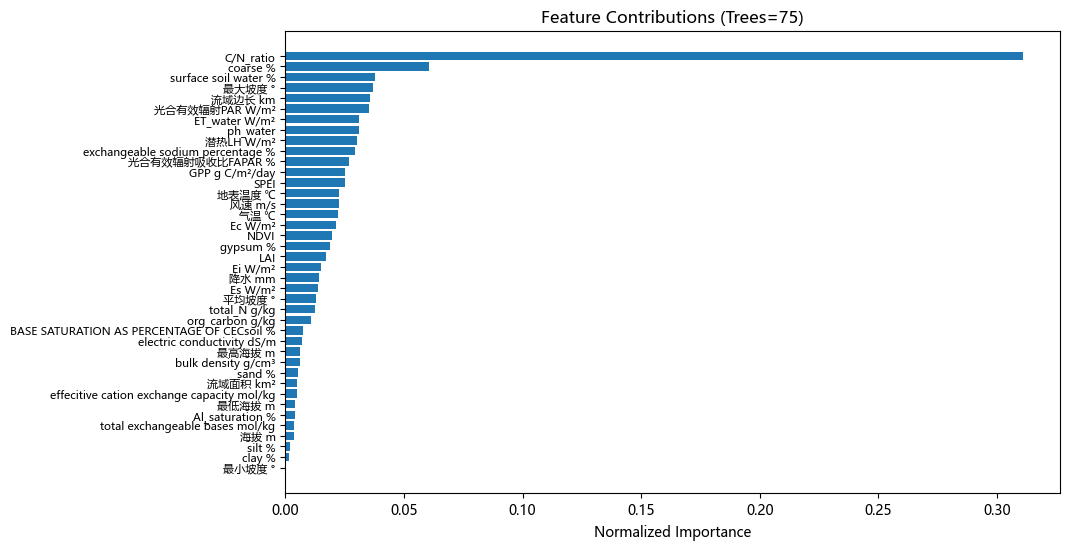

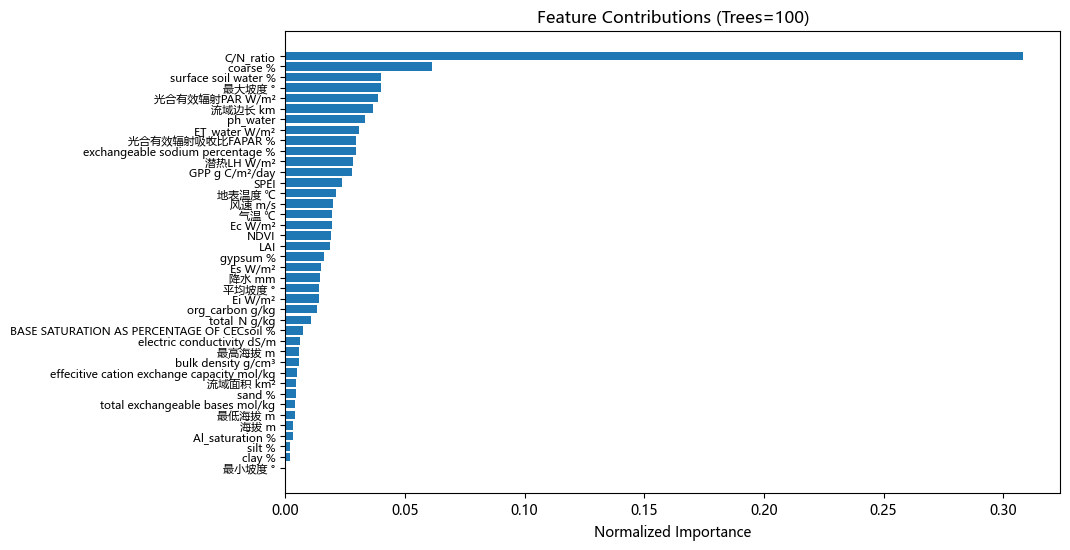

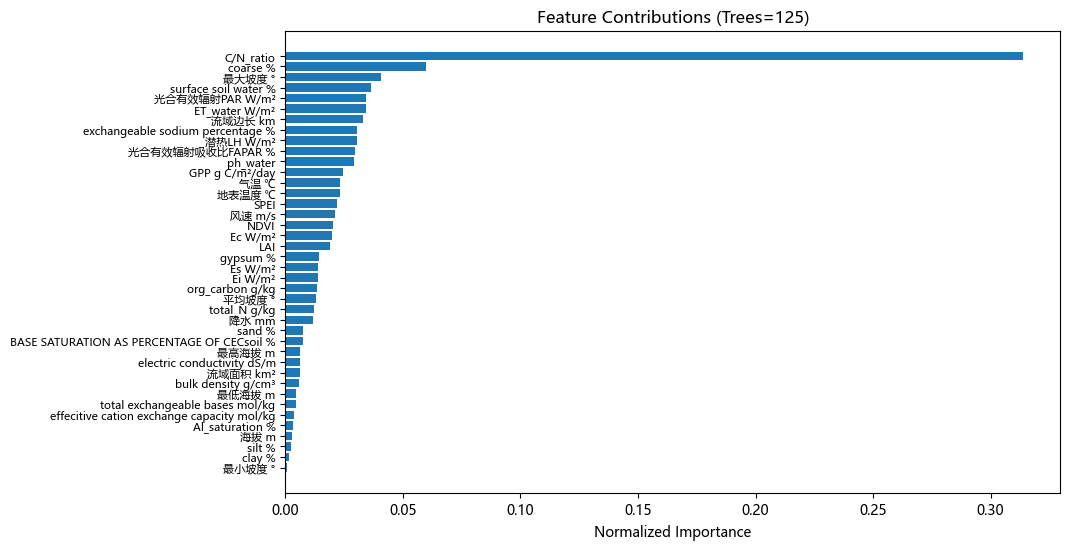

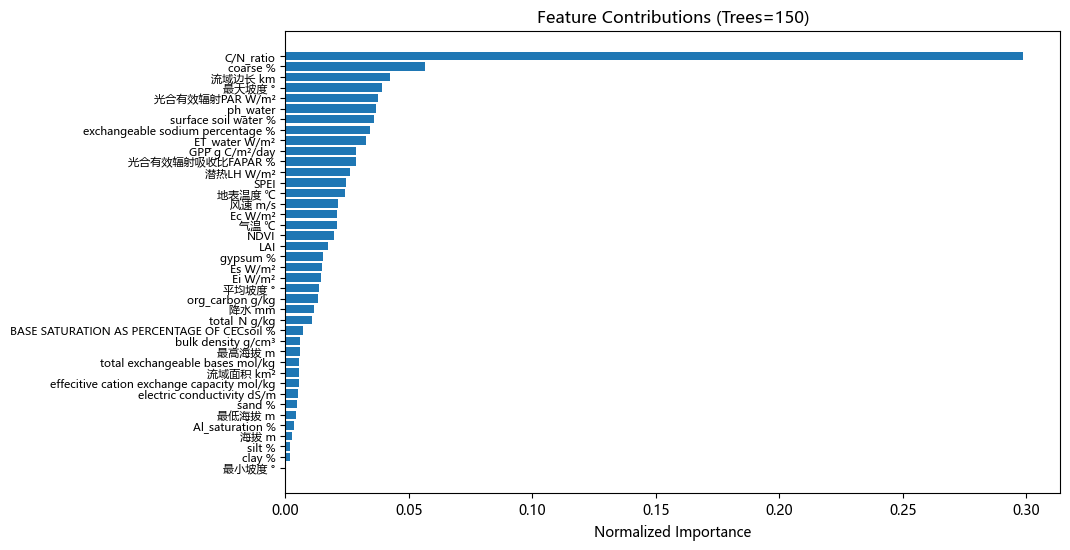

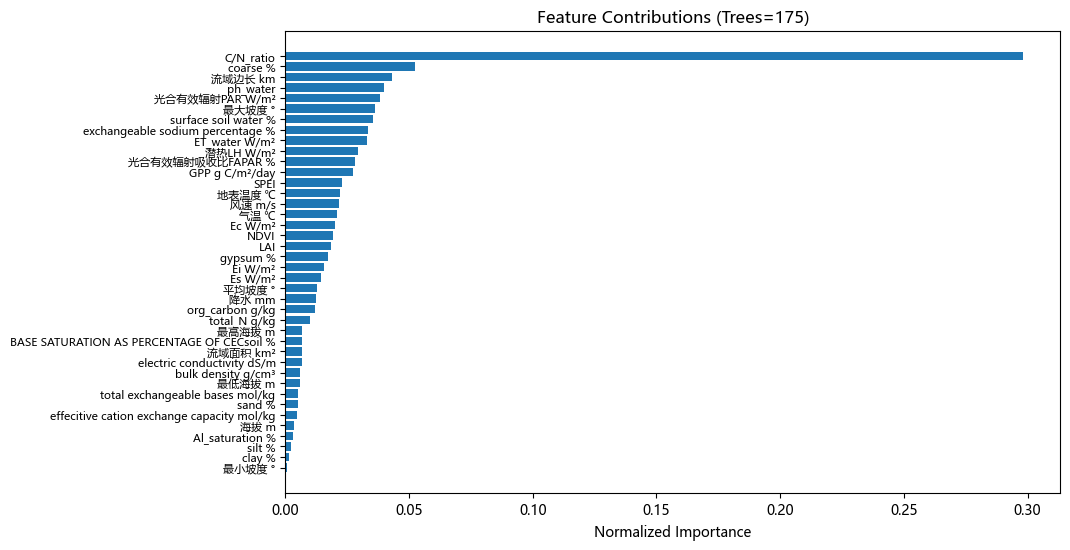

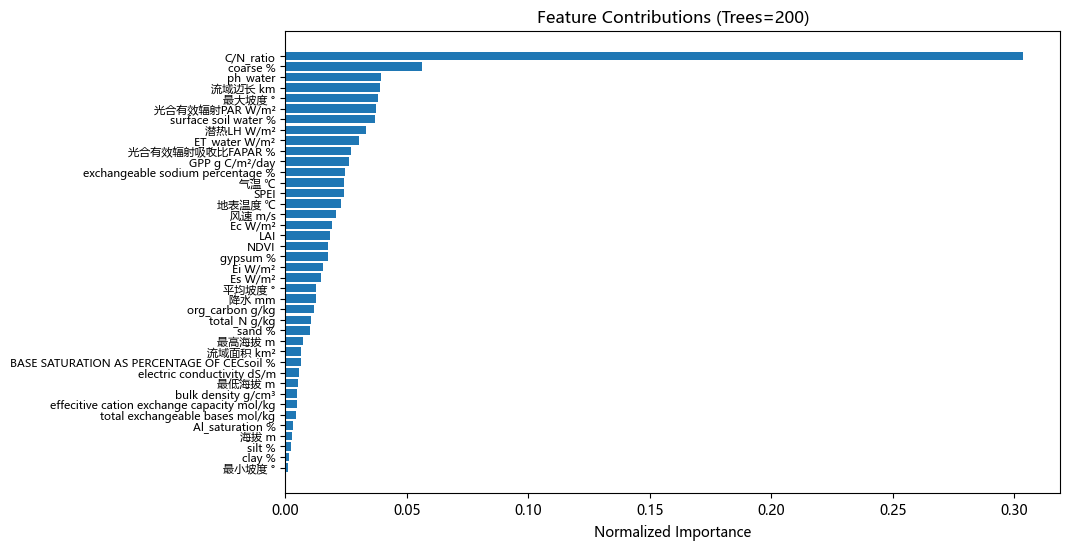

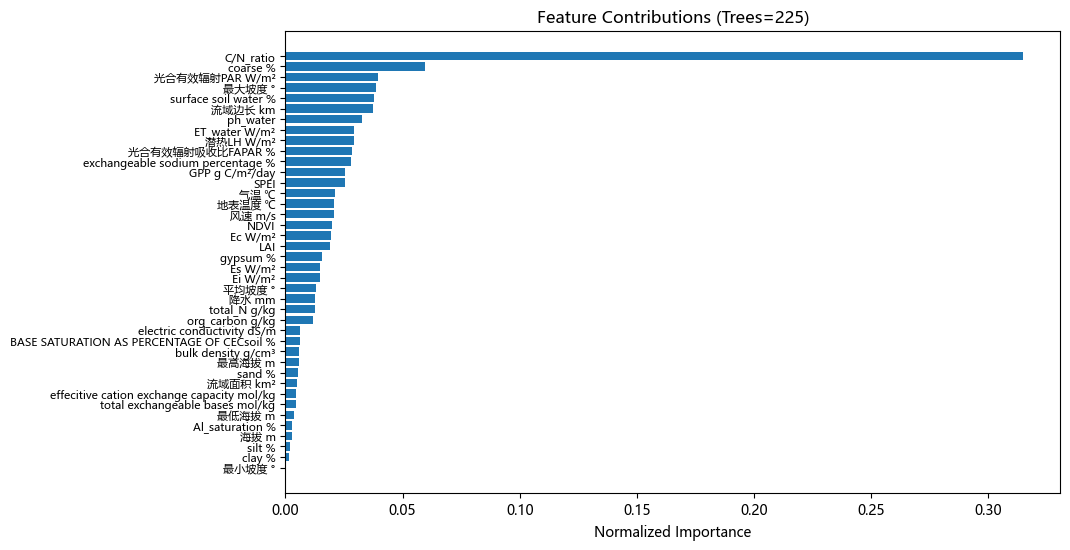

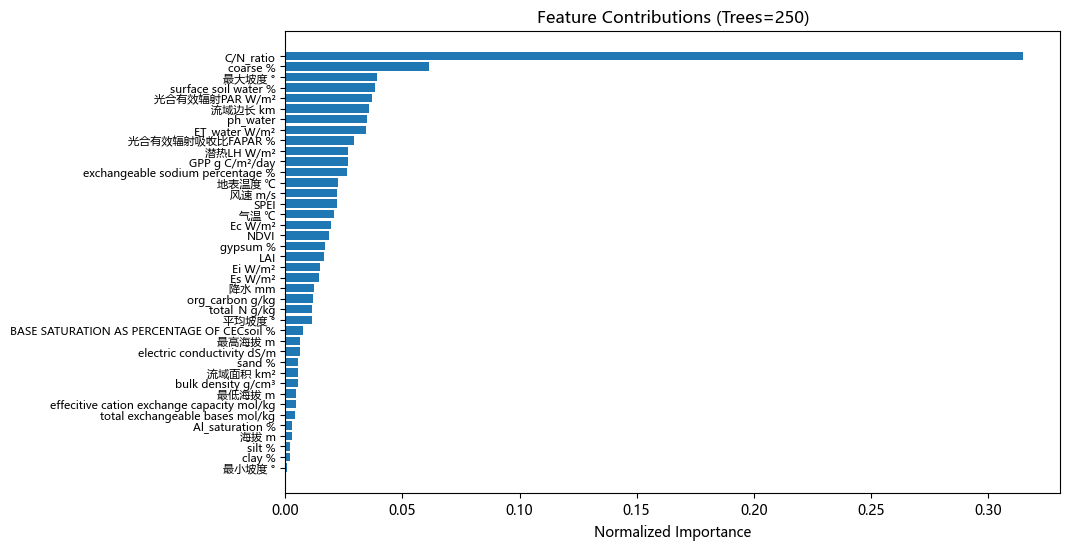

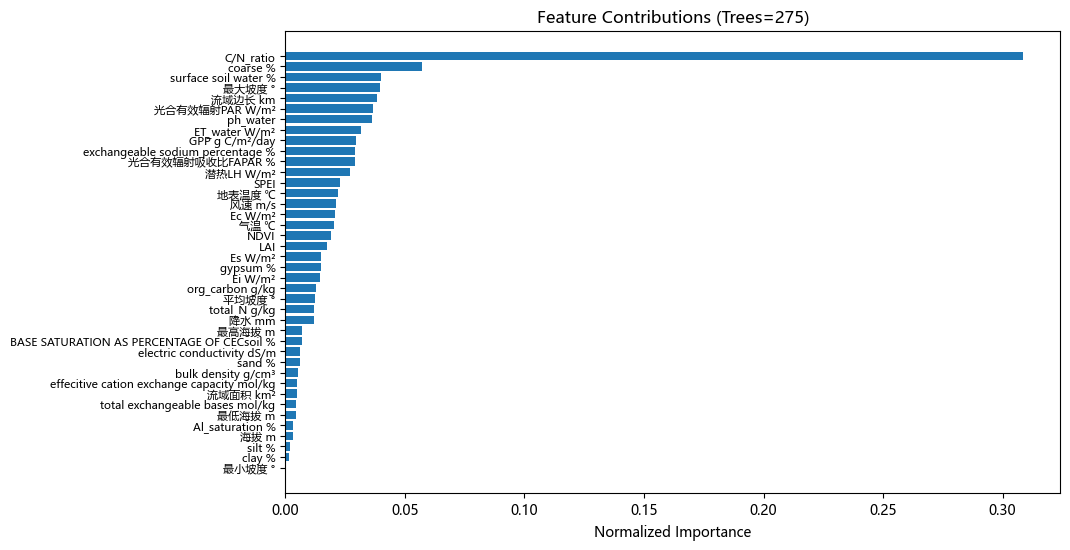

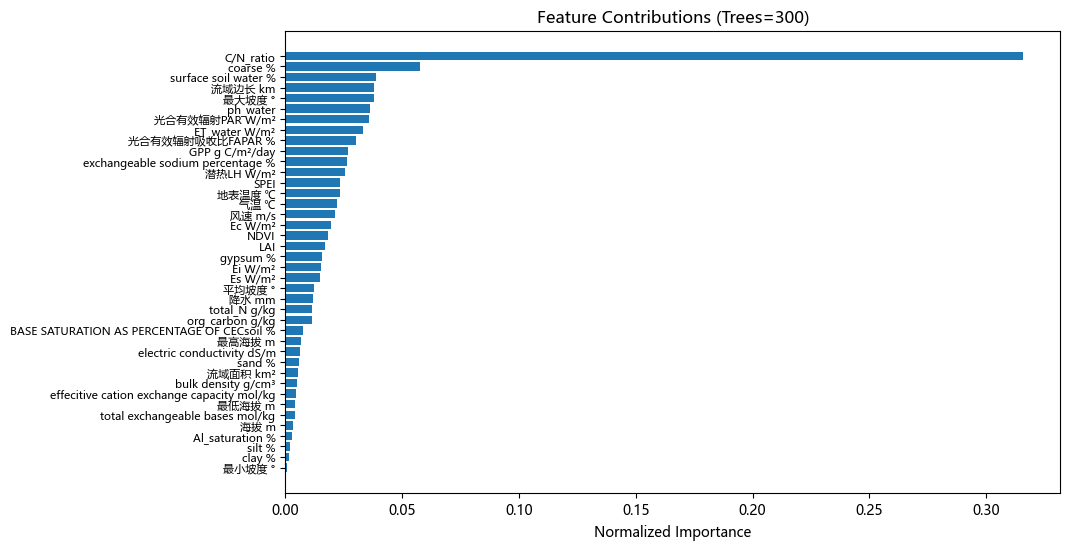

In [6]:
# 特征和标签
x = df_interpolate.drop('重碳酸根离子(HCO3- ) mg/L', axis=1)
t = df_interpolate['重碳酸根离子(HCO3- ) mg/L']

# 对整个数据集进行标准化处理
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
t_scaled = scaler.fit_transform(t.values.reshape(-1, 1))

column_names = x.columns.to_list()
feature_importance_dict = {}

# 划分训练集和测试集
x_train, x_test, t_train, t_test = train_test_split(x_scaled, t_scaled, test_size=0.2, random_state=seed_value)

# 超参数
tree_numbers = list(range(25, 325, 25))
matplotlib.rcParams['font.family'] = 'Microsoft YaHei'


# 绘制特征贡献图
for tree_number in tree_numbers:
    # print(f"\n\n\nNumber of trees in RF is {tree_number}")
    model = RandomForestRegressor(n_estimators=tree_number)
    # 初始化交叉验证
    kf = KFold(n_splits=5, shuffle=True)

    feature_importances_list = []

    for train_index, test_index in kf.split(x_train):
        x_fold_train, x_fold_test = x_train[train_index], x_train[test_index]
        t_fold_train, t_fold_test = t_train[train_index], t_train[test_index]
        model.fit(x_fold_train, t_fold_train.flatten())
        feature_importances_list.append(model.feature_importances_)
    
    feature_importance_dict[tree_number] = np.mean(feature_importances_list, axis=0)

# 绘制特征贡献图
for tree_number, importance in feature_importance_dict.items():
    sorted_indices = np.argsort(importance)[::-1]
    plt.figure(figsize=(10, 6))
    plt.barh([column_names[idx] for idx in sorted_indices], [importance[idx] for idx in sorted_indices])
    plt.xlabel('Normalized Importance')
    plt.title(f'Feature Contributions (Trees={tree_number})')
    plt.gca().invert_yaxis()
    plt.yticks(fontsize=8) 
    plt.show()





Number of trees in RF is 25


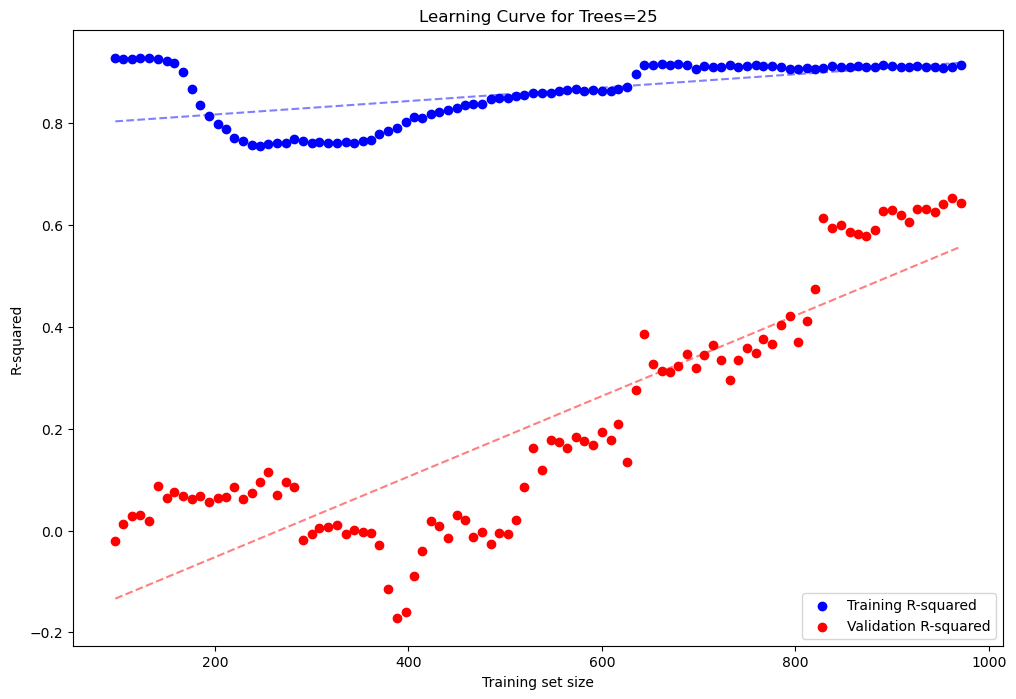




Number of trees in RF is 50


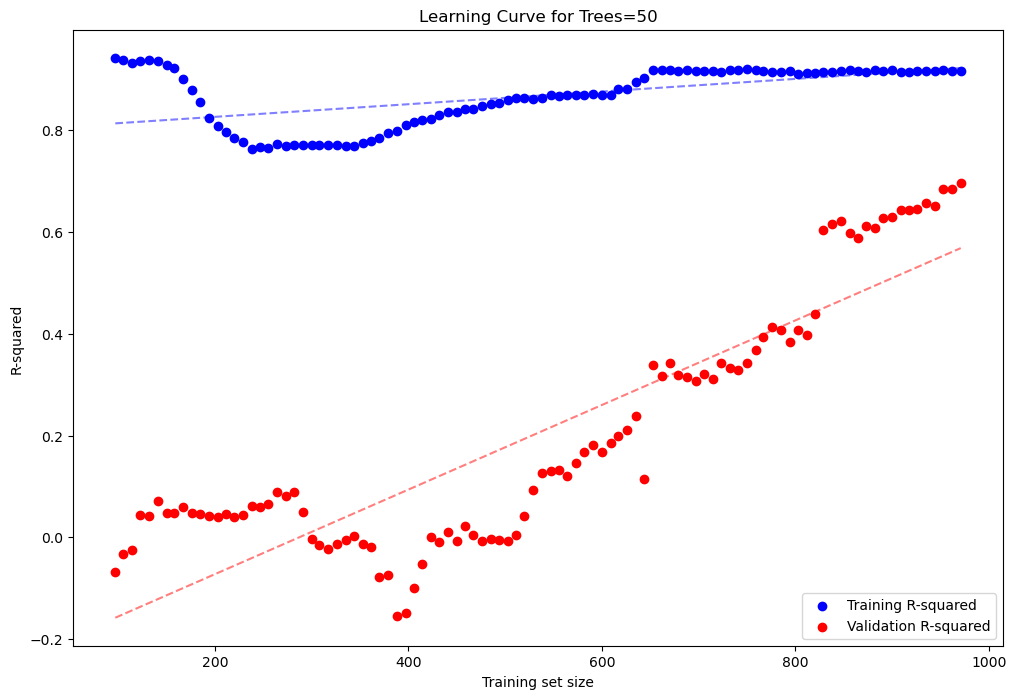




Number of trees in RF is 75


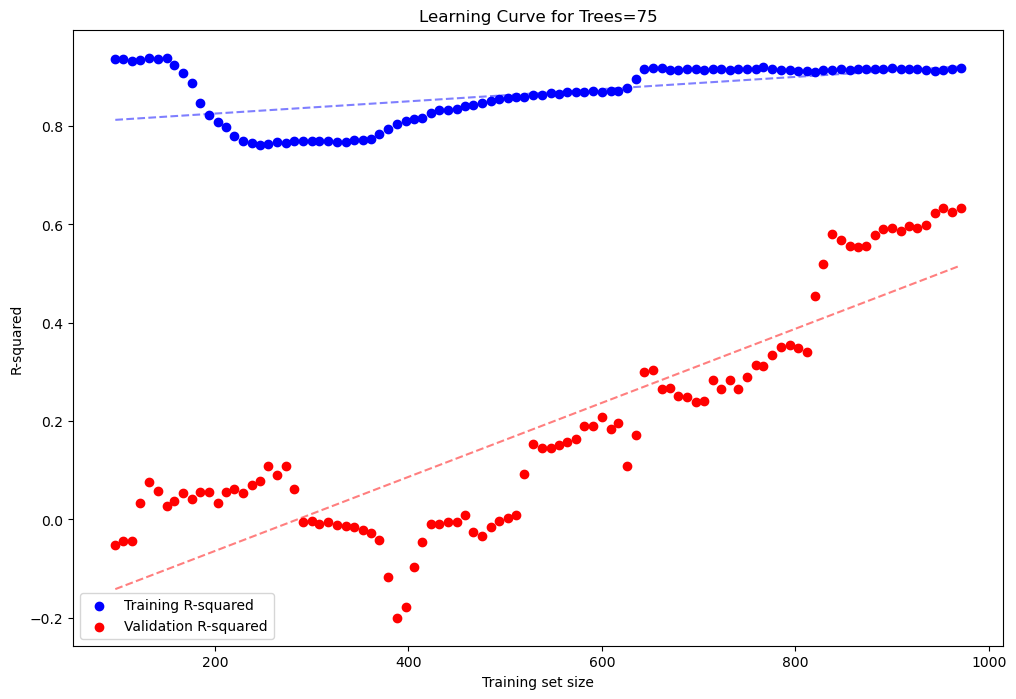




Number of trees in RF is 100


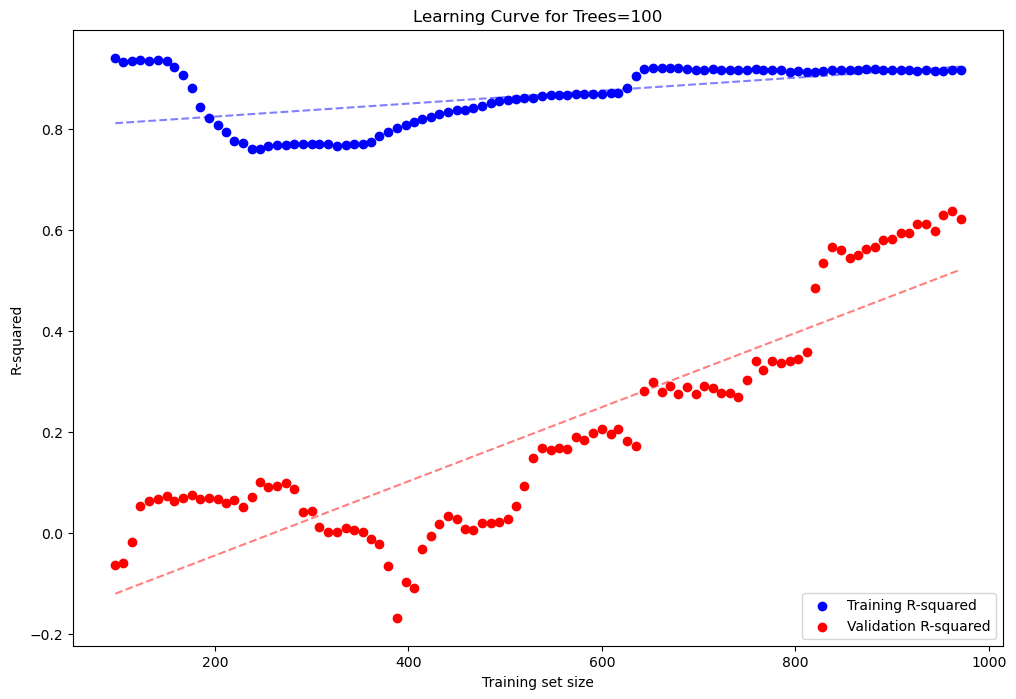




Number of trees in RF is 125


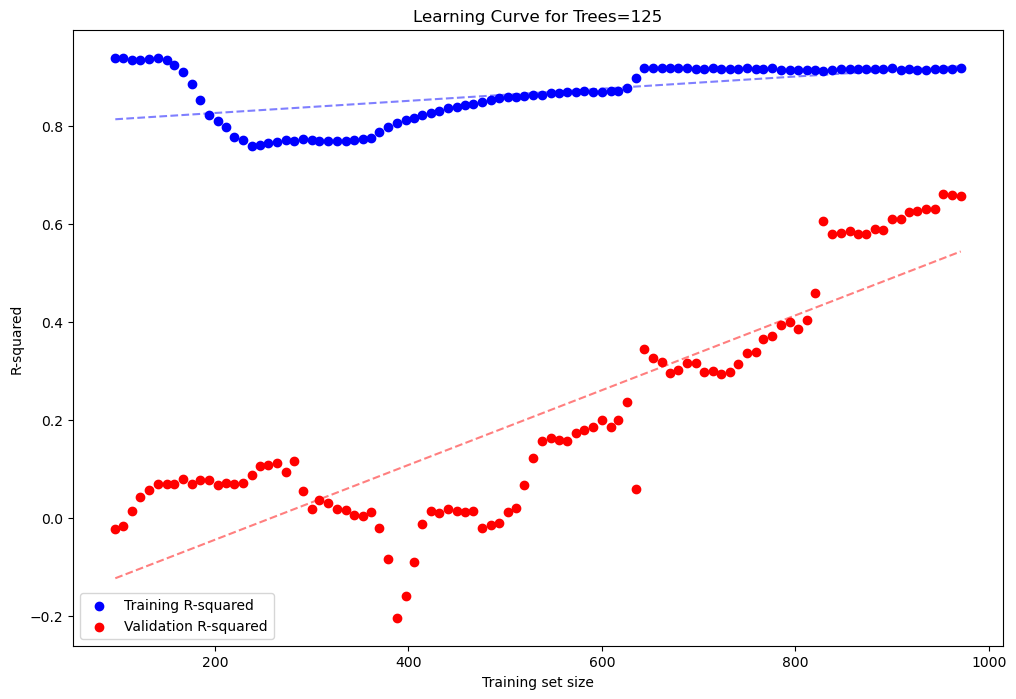




Number of trees in RF is 150


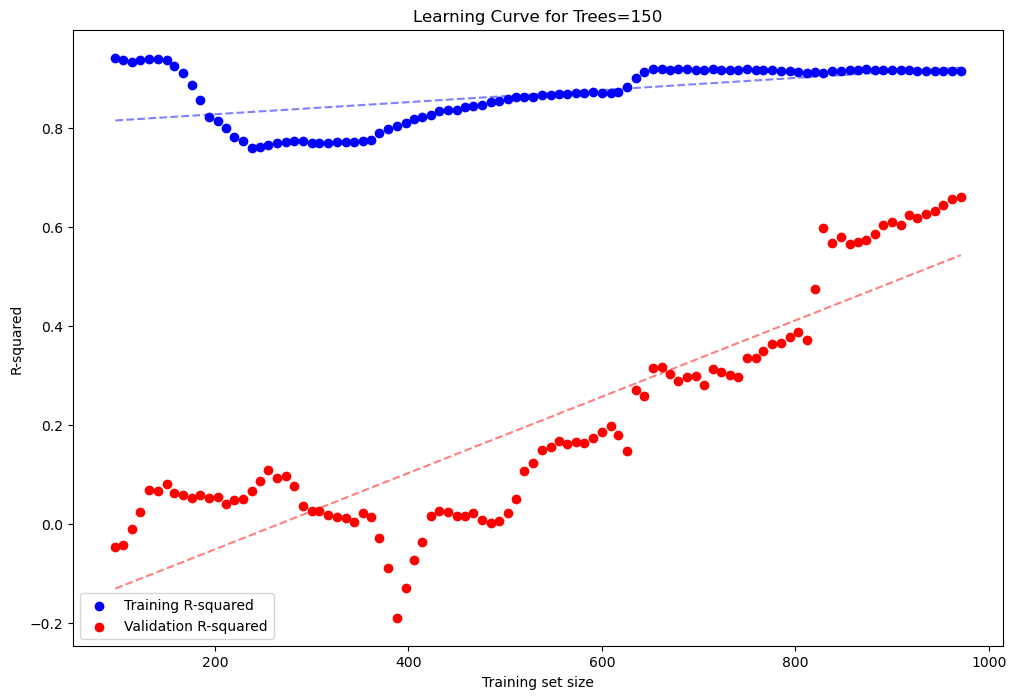




Number of trees in RF is 175


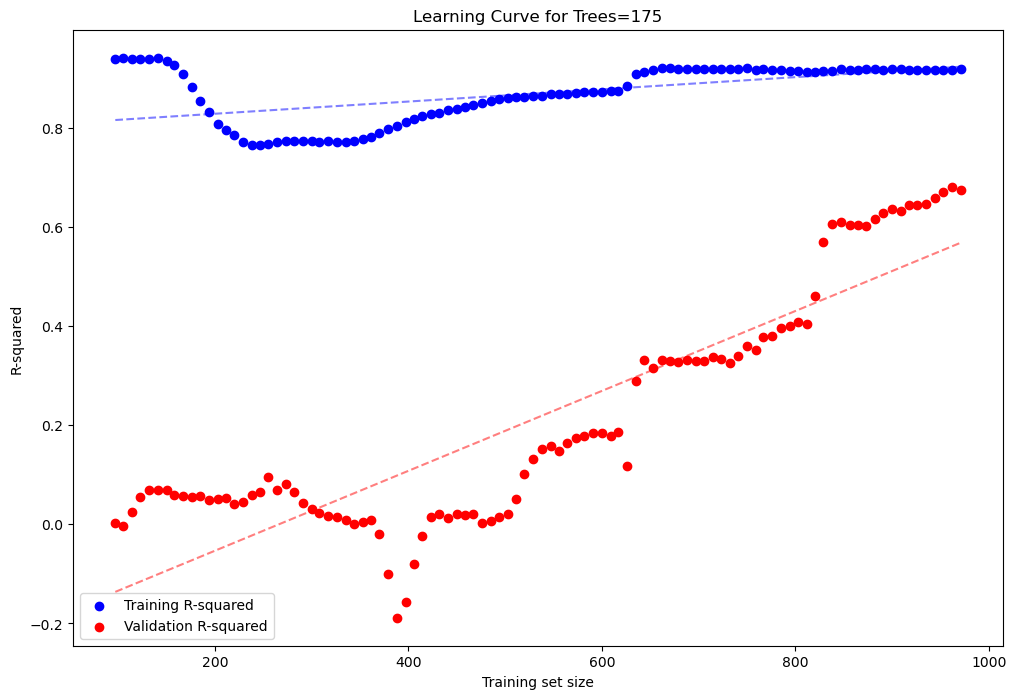




Number of trees in RF is 200


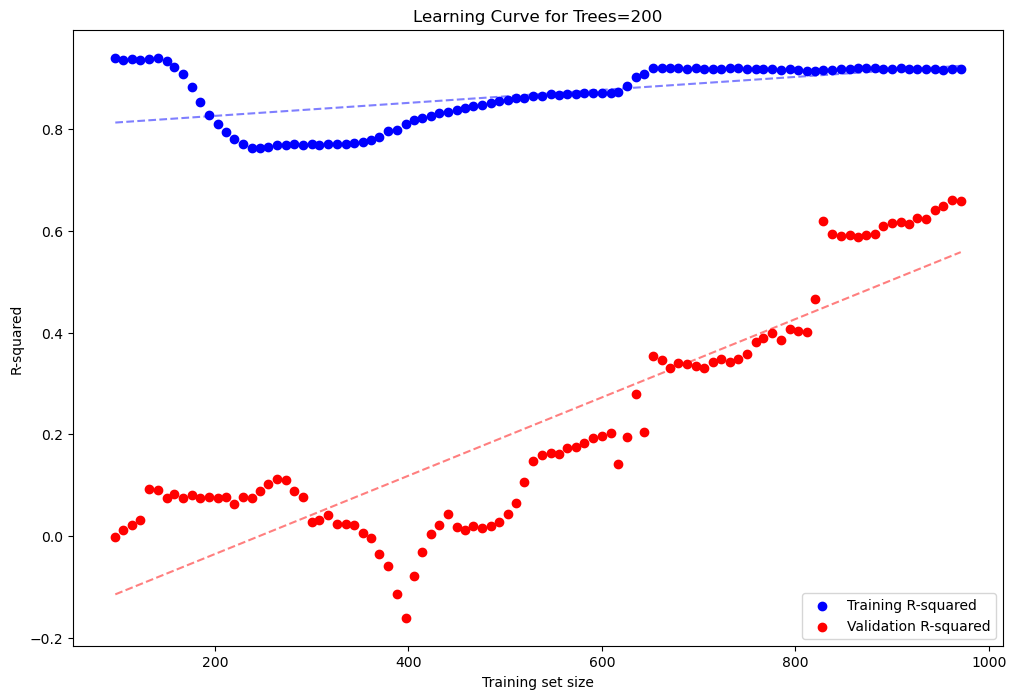




Number of trees in RF is 225


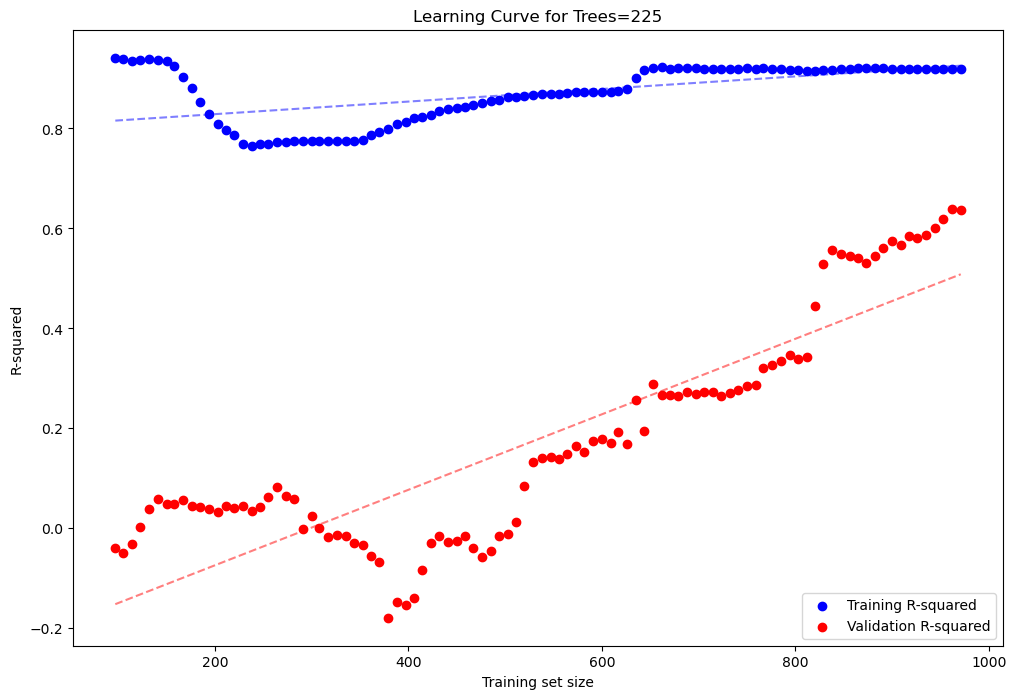




Number of trees in RF is 250


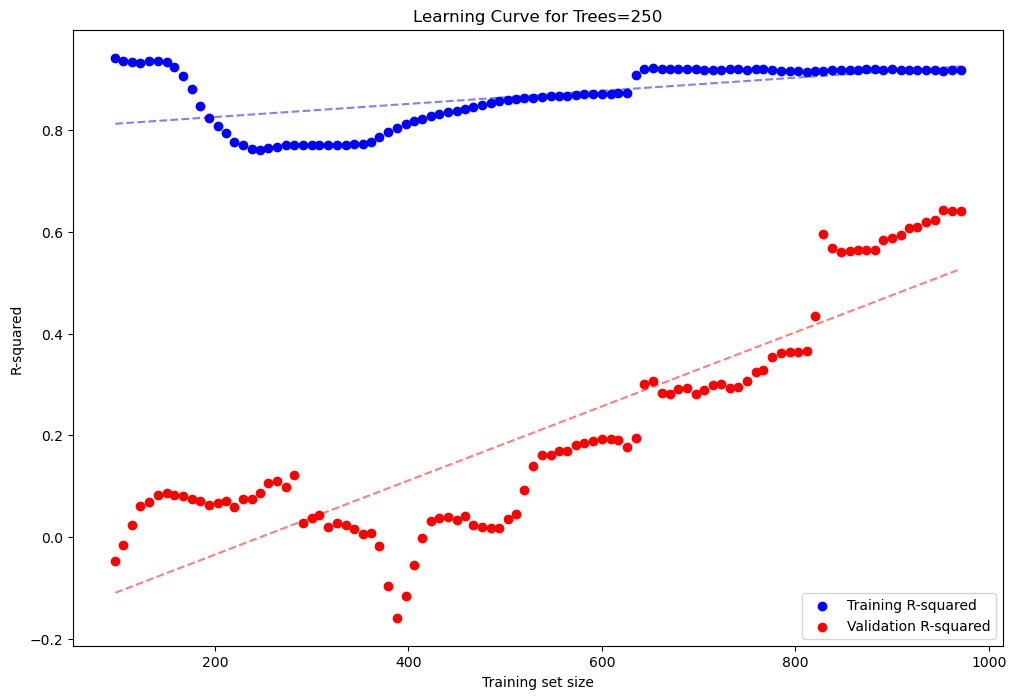




Number of trees in RF is 275


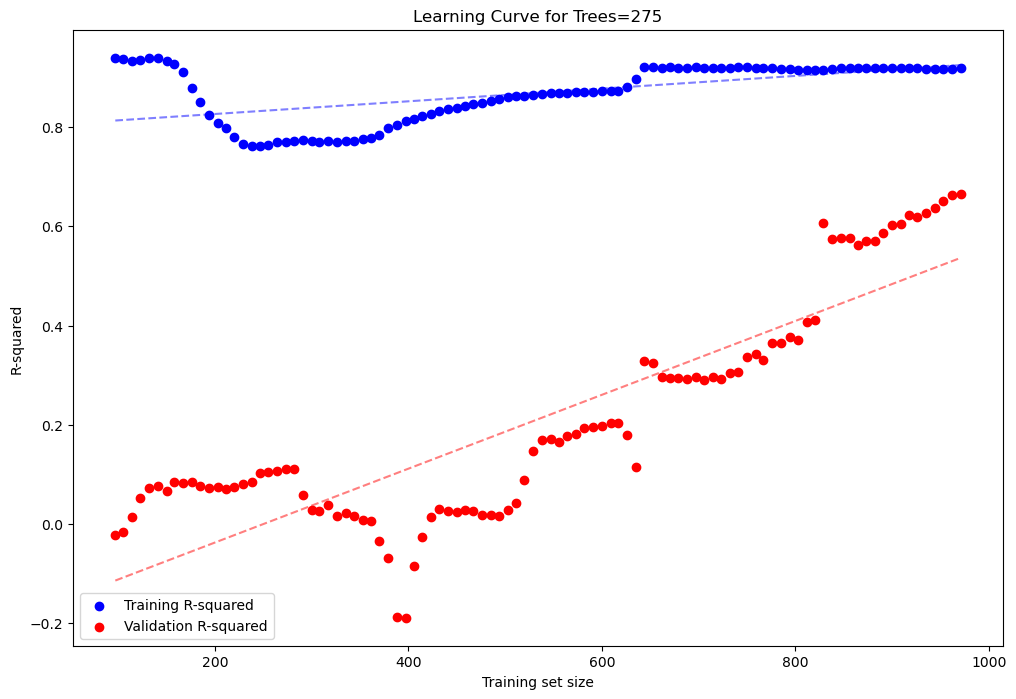




Number of trees in RF is 300


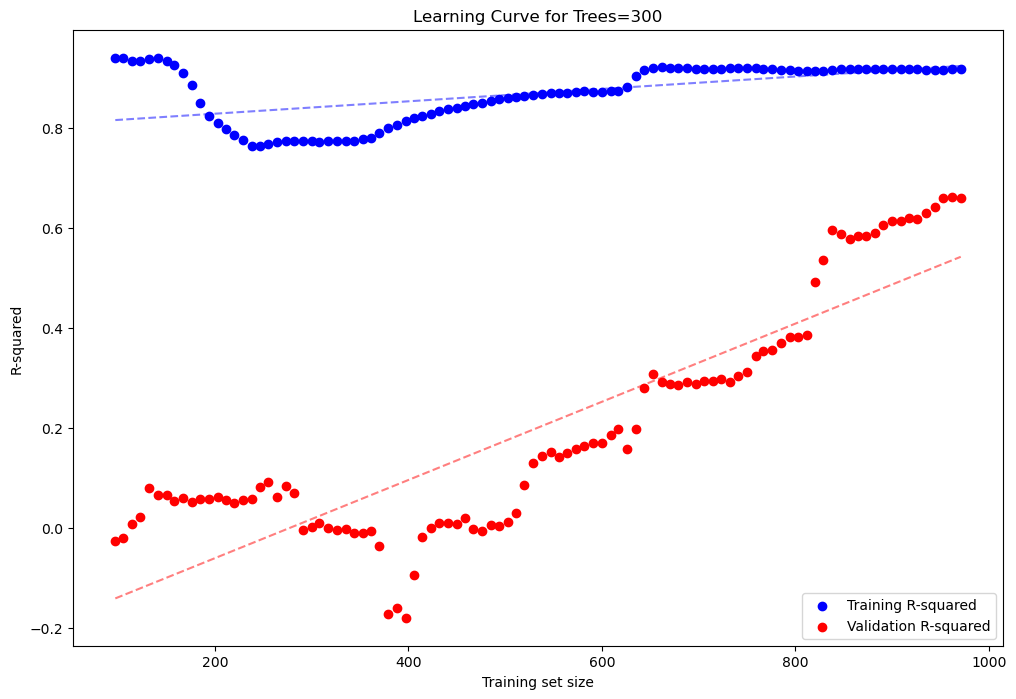

In [4]:
# 特征和标签
x = df_interpolate.drop('重碳酸根离子(HCO3- ) mg/L', axis=1)
t = df_interpolate['重碳酸根离子(HCO3- ) mg/L']

# 对整个数据集进行标准化处理
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
t_scaled = scaler.fit_transform(t.values.reshape(-1, 1))

# 超参数
tree_numbers = list(range(25, 325, 25))

# 划分训练集和测试集
x_train, x_test, t_train, t_test = train_test_split(x_scaled, t_scaled, test_size=0.2, random_state=seed_value)

for tree_number in tree_numbers:
    print(f"\n\n\nNumber of trees in RF is {tree_number}")
    model = RandomForestRegressor(n_estimators=tree_number)
    kf = KFold(n_splits=5, shuffle=True)
    
    train_sizes, train_scores, validation_scores = learning_curve(
        model, x_train, t_train.flatten(), cv=kf, scoring='r2', 
        train_sizes=np.linspace(0.1, 1.0, 100)
    )

    # 计算平均的训练集和验证集分数
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)

    plt.figure(figsize=(12, 8))
    plt.scatter(train_sizes, train_scores_mean, label='Training R-squared', color='blue', marker='o')
    plt.scatter(train_sizes, validation_scores_mean, label='Validation R-squared', color='red', marker='o')
        
    reg = LinearRegression()
    reg.fit(train_sizes.reshape(-1, 1), train_scores_mean)
    plt.plot(train_sizes, reg.predict(train_sizes.reshape(-1, 1)), color='blue', linestyle='--', alpha=0.5)
        
    reg.fit(train_sizes.reshape(-1, 1), validation_scores_mean)
    plt.plot(train_sizes, reg.predict(train_sizes.reshape(-1, 1)), color='red', linestyle='--', alpha=0.5)

    plt.xlabel('Training set size')
    plt.ylabel('R-squared')
    plt.title(f"Learning Curve for Trees={tree_number}")
    plt.legend()
    plt.show()